In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.dates import  DateFormatter
from pyspark.sql.functions import  col,  to_date
import datetime as dt
import findspark
from pyspark.sql import SparkSession

findspark.init()

# Tạo SparkSession
spark = SparkSession.builder.getOrCreate()

# Tạo dataframe từ file AAPL.csv
df = spark.read.csv('AAPL.csv', header=True, inferSchema=True)

In [2]:
# Hiển thị DataFrame và các thông tin cần thiết khác về dữ liệu
df.show()
df.printSchema()
df.collect()

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|02/01/1990|0.314732|0.334821|  0.3125|0.332589| 0.266423|183198400|
|03/01/1990|0.339286|0.339286|0.334821|0.334821| 0.268211|207995200|
|04/01/1990|0.341518|0.345982|0.332589|0.335938| 0.269106|221513600|
|05/01/1990|0.337054|0.341518|0.330357|0.337054|     0.27|123312000|
|08/01/1990|0.334821|0.339286|0.330357|0.339286| 0.271788|101572800|
|09/01/1990|0.339286|0.339286|0.330357|0.335938| 0.269106| 86139200|
|10/01/1990|0.335938|0.335938|0.319196|0.321429| 0.257484|199718400|
|11/01/1990|0.323661|0.323661|0.308036|0.308036| 0.246755|211052800|
|12/01/1990|0.305804|0.310268|0.301339|0.308036| 0.246755|171897600|
|15/01/1990|0.308036|0.319196|0.305804|0.305804| 0.244967|161739200|
|16/01/1990|0.299107|  0.3125|0.292411|0.311384| 0.249437|214244800|
|17/01/1990|0.310268|0.310268|0.29

[Row(Date='02/01/1990', Open=0.314732, High=0.334821, Low=0.3125, Close=0.332589, Adj Close=0.266423, Volume=183198400),
 Row(Date='03/01/1990', Open=0.339286, High=0.339286, Low=0.334821, Close=0.334821, Adj Close=0.268211, Volume=207995200),
 Row(Date='04/01/1990', Open=0.341518, High=0.345982, Low=0.332589, Close=0.335938, Adj Close=0.269106, Volume=221513600),
 Row(Date='05/01/1990', Open=0.337054, High=0.341518, Low=0.330357, Close=0.337054, Adj Close=0.27, Volume=123312000),
 Row(Date='08/01/1990', Open=0.334821, High=0.339286, Low=0.330357, Close=0.339286, Adj Close=0.271788, Volume=101572800),
 Row(Date='09/01/1990', Open=0.339286, High=0.339286, Low=0.330357, Close=0.335938, Adj Close=0.269106, Volume=86139200),
 Row(Date='10/01/1990', Open=0.335938, High=0.335938, Low=0.319196, Close=0.321429, Adj Close=0.257484, Volume=199718400),
 Row(Date='11/01/1990', Open=0.323661, High=0.323661, Low=0.308036, Close=0.308036, Adj Close=0.246755, Volume=211052800),
 Row(Date='12/01/1990',

In [3]:
# Thêm cột Avg_price vào DataFrame
df = df.withColumn("Avg_price", (col("Open") + col("Close")) / 2)
print("=================================================================")
print("DataFrame sau khi đã được thêm cột Avg_price ")
df.show()

DataFrame sau khi đã được thêm cột Avg_price 
+----------+--------+--------+--------+--------+---------+---------+-------------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|          Avg_price|
+----------+--------+--------+--------+--------+---------+---------+-------------------+
|02/01/1990|0.314732|0.334821|  0.3125|0.332589| 0.266423|183198400|          0.3236605|
|03/01/1990|0.339286|0.339286|0.334821|0.334821| 0.268211|207995200|          0.3370535|
|04/01/1990|0.341518|0.345982|0.332589|0.335938| 0.269106|221513600|0.33872800000000003|
|05/01/1990|0.337054|0.341518|0.330357|0.337054|     0.27|123312000|           0.337054|
|08/01/1990|0.334821|0.339286|0.330357|0.339286| 0.271788|101572800|          0.3370535|
|09/01/1990|0.339286|0.339286|0.330357|0.335938| 0.269106| 86139200|           0.337612|
|10/01/1990|0.335938|0.335938|0.319196|0.321429| 0.257484|199718400|          0.3286835|
|11/01/1990|0.323661|0.323661|0.308036|0.308036| 0.246755|211052

In [4]:
# Hiển thị các thông số mô tả bộ dữ liệu
print("=================================================================")
print("Các thông số mô tả bộ dữ liệu")
df.describe().show()

Các thông số mô tả bộ dữ liệu
+-------+----------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+
|summary|      Date|              Open|              High|               Low|             Close|         Adj Close|              Volume|         Avg_price|
+-------+----------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+
|  count|      8042|              8042|              8042|              8042|              8042|              8042|                8042|              8042|
|   mean|      null| 16.35191723141012| 16.52506552138771|16.178668041531957|16.358983063541427|15.594377369062439|  3.83183207224571E8|16.355450147475743|
| stddev|      null|29.698128840069888|30.021799458231847|29.380971071199873|29.717859811650726|29.448484978132356|3.6330954509115946E8| 29.70697684899139|
|    min|01/02/1990|          0.11

In [5]:
# In ra 2 cột chính Date và Avg_price
print("=================================================================")
print("DataFrame gồm 2 cột Date và Avg_price")
df_avg_price = df.select('Date', 'Avg_price')
df_avg_price.show()

DataFrame gồm 2 cột Date và Avg_price
+----------+-------------------+
|      Date|          Avg_price|
+----------+-------------------+
|02/01/1990|          0.3236605|
|03/01/1990|          0.3370535|
|04/01/1990|0.33872800000000003|
|05/01/1990|           0.337054|
|08/01/1990|          0.3370535|
|09/01/1990|           0.337612|
|10/01/1990|          0.3286835|
|11/01/1990|          0.3158485|
|12/01/1990|0.30691999999999997|
|15/01/1990|0.30691999999999997|
|16/01/1990|          0.3052455|
|17/01/1990|          0.3035715|
|18/01/1990|0.29185300000000003|
|19/01/1990|          0.3035715|
|22/01/1990|           0.300223|
|23/01/1990|           0.301339|
|24/01/1990|           0.296875|
|25/01/1990|           0.305246|
|26/01/1990|           0.297991|
|29/01/1990|           0.295759|
+----------+-------------------+
only showing top 20 rows



Biểu đồ giá theo thời gian


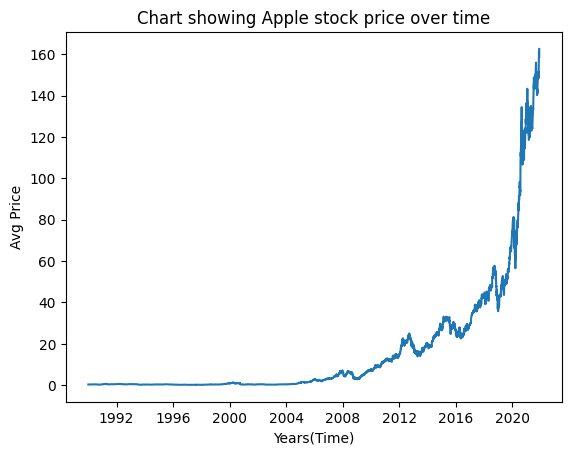

In [6]:
# Chuyển đổi định dạng ngày tháng
df_avg_price = df_avg_price.withColumn('Date', to_date(df['Date'], 'dd/MM/yyyy'))
# Chuyển đổi DataFrame thành một mảng NumPy
arr = df_avg_price.toPandas().values

# Tách cột Date và cột Avg_price thành 2 mảng riêng
dates = arr[:, 0]
avg_prices = arr[:, 1]

# Tạo biểu đồ đường
plt.plot(dates, avg_prices)

# Đặt tên cho các trục và hiển thị biểu đồ
plt.xlabel("Years(Time)")
plt.ylabel("Avg Price")
print("=================================================================")
print("Biểu đồ giá theo thời gian")
plt.title("Chart showing Apple stock price over time")
plt.show()

In [7]:
# Chuyển đổi định dạng ngày tháng
filtered_df = df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))

# Lọc dữ liệu
filtered_df = df.filter((to_date(col("Date"), "dd/MM/yyyy") >= "1990-01-02") & (to_date(col("Date"), "dd/MM/yyyy") <= "2009-01-02"))
num_rows = filtered_df.count()
print("=================================================================")
print("Số dòng từ ngày 2/1/1990 đến ngày 2/1/2009 là:", num_rows)


Số dòng từ ngày 2/1/1990 đến ngày 2/1/2009 là: 4792


In [8]:
# Đổi định dạng cột Date sang ngày tháng năm
df = df.withColumn('Date', to_date(df['Date'], 'dd/MM/yyyy'))

# Chia bộ dữ liệu ra thành 2 trước và sau ngày 2/1/2009
filtered_df = df.filter(col('Date') >= '2009-01-02')
new_df = filtered_df.select('Date', 'Avg_price')
print("=================================================================")
print("DataFrame từ ngày 2/1/2009 trở về sau")
new_df.show()

DataFrame từ ngày 2/1/2009 trở về sau
+----------+------------------+
|      Date|         Avg_price|
+----------+------------------+
|2009-01-02|3.1541069999999998|
|2009-01-05|         3.3526785|
|2009-01-06|         3.3744645|
|2009-01-07|3.2646430000000004|
|2009-01-08|         3.2701785|
|2009-01-09|         3.2819645|
|2009-01-12|         3.1985715|
|2009-01-13|         3.1419645|
|2009-01-14|3.0637499999999998|
|2009-01-15|         2.9276785|
|2009-01-16|2.9755355000000003|
|2009-01-20|          2.859464|
|2009-01-21|         2.8967855|
|2009-01-22|3.1500000000000004|
|2009-01-23|          3.128214|
|2009-01-26|            3.1875|
|2009-01-27|          3.230714|
|2009-01-28|          3.327143|
|2009-01-29|          3.323036|
|2009-01-30|          3.263036|
+----------+------------------+
only showing top 20 rows



Biểu đồ giá theo thời gian theo DataFrame mới


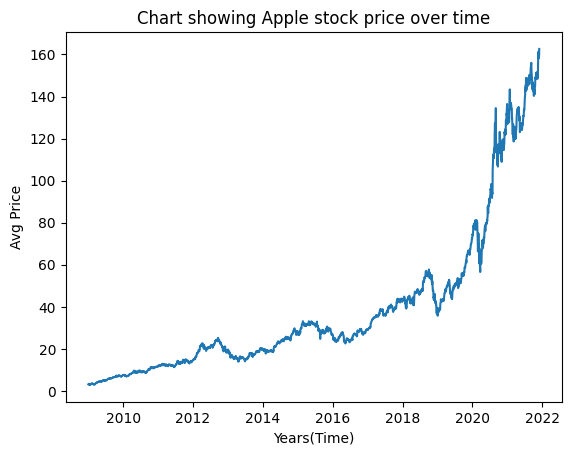

In [9]:
# Chuyển đổi DataFrame thành một mảng NumPy
arr = new_df.toPandas().values

# Tách cột Date và cột Avg_price thành 2 mảng riêng
dates = arr[:, 0]
avg_prices = arr[:, 1]

# Tạo biểu đồ đường
plt.plot(dates, avg_prices)

# Đặt tên cho các trục và hiển thị biểu đồ
plt.xlabel("Years(Time)")
plt.ylabel("Avg Price")
print("=================================================================")
print("Biểu đồ giá theo thời gian theo DataFrame mới")
plt.title("Chart showing Apple stock price over time")
plt.show()

In [10]:
# Chia dữ DataFrame thành 2 tệp train  và test 
train_data = new_df.filter(col("Date") < "2021-05-30")
test_data = new_df.filter(col("Date") >= "2021-05-30")

# Chuyển tụi này sang Pandas Data Frame
train_data = train_data.toPandas()
test_data_pd = test_data.toPandas()
new_df = new_df.toPandas()


In [11]:
# Chuẩn hóa dữ liệu bằng MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data['Avg_price'].values.reshape(-1,1)
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data_pd = scaler.fit_transform(test_data_pd[['Avg_price']])

# Tạo model
model = Sequential()
n_features = 1 # số lượng đặc trưng đầu vào
n_input = 126

# Định nghĩa mô hình LSTM
model.add(LSTM(units=100, return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(25))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Sử dụng EarlyStopping để dừng huấn luyện nếu không có sự cải thiện về độ chính xác
early_stop = EarlyStopping(monitor='val_loss', patience=10)
print("=================================================================")
print("In ra các thông só của mô hình LSTM")
model.summary()


In ra các thông só của mô hình LSTM
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 126, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 126, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 126, 50)           30200     
                                                                 
 dropout_1 (Dropout)         (None, 126, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense (Dense)      

In [12]:
# Tạo TimeSeriesGenerator để phát sinh chuỗi thời gian
train_generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=32)

# Tạo generator cho dữ liệu kiểm tra
test_generator = TimeseriesGenerator(test_data_pd, test_data_pd, length=n_input, batch_size=32)
print("=================================================================")
print("Hiển thị quá trình huấn luyện mô hình")
# Huấn luyện mô hình
model.fit(train_generator, epochs=50, validation_data=(test_generator), callbacks=[early_stop])


Hiển thị quá trình huấn luyện mô hình
Epoch 1/50
94/94 [==============================] - 30s 239ms/step - loss: 0.0165 - val_loss: 0.0549
Epoch 2/50
94/94 [==============================] - 27s 284ms/step - loss: 0.0032 - val_loss: 0.0855
Epoch 3/50
94/94 [==============================] - 23s 242ms/step - loss: 0.0031 - val_loss: 0.0376
Epoch 4/50
94/94 [==============================] - 19s 201ms/step - loss: 0.0032 - val_loss: 0.0494
Epoch 5/50
94/94 [==============================] - 23s 248ms/step - loss: 0.0024 - val_loss: 0.0319
Epoch 6/50
94/94 [==============================] - 25s 266ms/step - loss: 0.0026 - val_loss: 0.0385
Epoch 7/50
94/94 [==============================] - 21s 228ms/step - loss: 0.0016 - val_loss: 0.0415
Epoch 8/50
94/94 [==============================] - 25s 263ms/step - loss: 0.0024 - val_loss: 0.1286
Epoch 9/50
94/94 [==============================] - 22s 234ms/step - loss: 0.0026 - val_loss: 0.0276
Epoch 10/50
94/94 [==============================] - 

Hiển thị biểu đồ giá trị loss và val_loss


<AxesSubplot:>

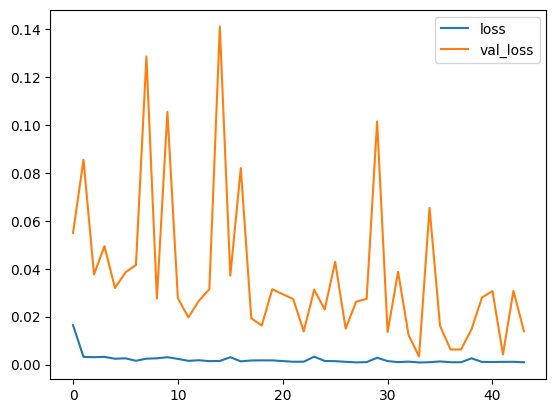

In [13]:
print("=================================================================")
print("Hiển thị biểu đồ giá trị loss và val_loss")
loss = pd.DataFrame(model.history.history)
loss.plot()


In [14]:
# Dự đoán giá cổ phiếu của Apple
# Tạo mảng test_predictions
test_predictions = []
current_batch = train_data[-n_input:].reshape((1, n_input, n_features))

print("=================================================================")
print("Hiển thị quá trình thực thi mô hình")
# Sử dụng vòng lặp để dự đoán tất cả các giá trị có trong test_data_pd
for i in range(len(test_data_pd)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :],[[current_pred]],axis=1)


Hiển thị quá trình thực thi mô hình
1/1 [==============================] - 0s 51ms/step


In [15]:
# Chuyển data frame test_predictions về dạng ban đầu
test_predictions = scaler.inverse_transform(test_predictions)
test_data= test_data.toPandas()
print("=================================================================")
print("In ra Data Frame của test_data (cho vui)")
test_data.head()


In ra Data Frame của test_data (cho vui)


,Date,Avg_price
0,2021-06-01,124.680001
1,2021-06-02,124.669998
2,2021-06-03,124.110001
3,2021-06-04,124.979999
4,2021-06-07,126.035000


In [16]:
# Tạo pandas DataFrame từ test_predictions
predictions_df = pd.DataFrame(test_predictions, columns=["Predictions"])

# Gộp predictions_df với test_data
test_data = pd.concat([test_data.iloc[0:len(predictions_df)], predictions_df], axis=1)
print("=================================================================")
print("In ra Data Frame của test_data sau khi thêm cột Predictions")
test_data.head()

In ra Data Frame của test_data sau khi thêm cột Predictions


,Date,Avg_price,Predictions
0,2021-06-01,124.680001,157.386602
1,2021-06-02,124.669998,157.351864
2,2021-06-03,124.110001,157.291262
3,2021-06-04,124.979999,157.215077
4,2021-06-07,126.035000,157.132732


Hiển thị biểu đồ giá thực tế và giá dự đoán


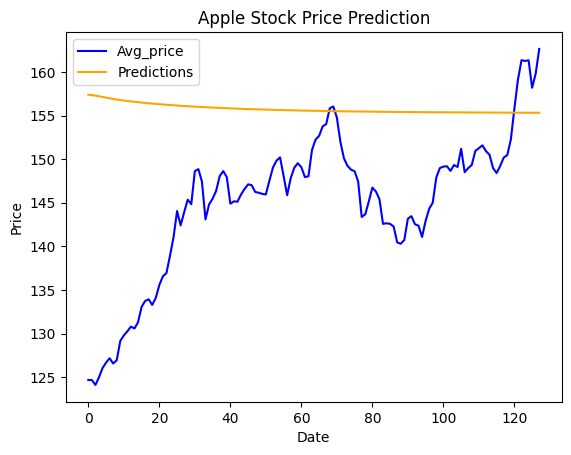

In [17]:
# Vẽ biểu đồ
plt.plot(test_data['Avg_price'], label='Avg_price', color='blue')
plt.plot(test_data['Predictions'], label='Predictions', color='orange')

# Đặt các thông số cho biểu đồ
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple Stock Price Prediction')
plt.legend()

# Hiển thị biểu đồ
print("=================================================================")
print("Hiển thị biểu đồ giá thực tế và giá dự đoán")
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error
print("=================================================================")
print("In ra độ đo MSE")
np.sqrt(mean_squared_error(test_data['Avg_price'],test_data['Predictions']))


In ra độ đo MSE


13.973748905074409

In [19]:
from dateutil.parser import parse
from dateutil.rrule import rrule, DAILY, MO, TU, WE, TH, FR

# Chọn ra các ngày trong tuần từ thứ 2 đến thứ 6
result = rrule(
  DAILY,
  byweekday=(MO,TU,WE,TH,FR),
  dtstart=parse('2021-12-01'),
  until=parse('2022-05-31')
)
print("=================================================================")
print("In ra danh sách các ngày sẽ dự đoán tiếp theo")
list(result)


In ra danh sách các ngày sẽ dự đoán tiếp theo


[datetime.datetime(2021, 12, 1, 0, 0),
 datetime.datetime(2021, 12, 2, 0, 0),
 datetime.datetime(2021, 12, 3, 0, 0),
 datetime.datetime(2021, 12, 6, 0, 0),
 datetime.datetime(2021, 12, 7, 0, 0),
 datetime.datetime(2021, 12, 8, 0, 0),
 datetime.datetime(2021, 12, 9, 0, 0),
 datetime.datetime(2021, 12, 10, 0, 0),
 datetime.datetime(2021, 12, 13, 0, 0),
 datetime.datetime(2021, 12, 14, 0, 0),
 datetime.datetime(2021, 12, 15, 0, 0),
 datetime.datetime(2021, 12, 16, 0, 0),
 datetime.datetime(2021, 12, 17, 0, 0),
 datetime.datetime(2021, 12, 20, 0, 0),
 datetime.datetime(2021, 12, 21, 0, 0),
 datetime.datetime(2021, 12, 22, 0, 0),
 datetime.datetime(2021, 12, 23, 0, 0),
 datetime.datetime(2021, 12, 24, 0, 0),
 datetime.datetime(2021, 12, 27, 0, 0),
 datetime.datetime(2021, 12, 28, 0, 0),
 datetime.datetime(2021, 12, 29, 0, 0),
 datetime.datetime(2021, 12, 30, 0, 0),
 datetime.datetime(2021, 12, 31, 0, 0),
 datetime.datetime(2022, 1, 3, 0, 0),
 datetime.datetime(2022, 1, 4, 0, 0),
 datetime.d

In [20]:
# Tạo mảng forecast_date
forecast_date = []

# Sử dụng vòng lặp để tạo trình thời gian chứa tất cả các số ngày thuộc thứ 2 đến thứ 6 của các ngày từ nàgy 12/1/2021 đến ngày 31/5/2022
for i in list(result):
    forecast_date.append(i.strftime('%Y-%m-%d'))
forecast_date_df = pd.DataFrame(forecast_date, columns=['Date'])
forecast_date_df['Date'] = pd.to_datetime(forecast_date_df['Date'], format='%Y-%m-%d')
print("=================================================================")
print("In ra số dòng sẽ dự đoán")
len(forecast_date_df)



In ra số dòng sẽ dự đoán


130

In [21]:
forecast = []
# Dự đoán giá cổ phiếu trong nữa năm đầu 2022
periods = 128
test_data_fc = scaler.fit_transform(test_data[['Avg_price']])
first_eval_batch = test_data_fc[-periods:]
current_batch = first_eval_batch.reshape((1, periods, n_features))

print("=================================================================")
print("Hiển thị quá trình thực thi mô hình trên forecast_date_df ")

# Sử dụng vòng lặp để dự đoán tất cả các giá trị có trong predios
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



Hiển thị quá trình thực thi mô hình trên forecast_date_df 
1/1 [==============================] - 0s 45ms/step


In [22]:
# Chuyển dữ liệu về dạng ban đầu
forecast = scaler.inverse_transform(forecast)

# Chuyển forecast thành pandas dataframe với tên cột Predictions
forecast_df = pd.DataFrame(forecast, columns=['Predictions'])

# Gộp forecast_date_df và forecast_df theo cột bằng hàm concat
forecast_data = pd.concat([forecast_date_df.iloc[0:len(forecast_df)], forecast_df], axis=1)
print("=================================================================")
print("In ra Data Frame của forecast_data")
forecast_data.head(130)

In ra Data Frame của forecast_data


,Date,Predictions
0,2021-12-01,157.778921
1,2021-12-02,158.088582
2,2021-12-03,158.155005
3,2021-12-06,158.058286
4,2021-12-07,157.875233
...,...,...
123,2022-05-23,155.334087
124,2022-05-24,155.332667
125,2022-05-25,155.331282
126,2022-05-26,155.329943


Hiển thị biểu đồ giá dự đoán từ ngày 1/12/2021 đến ngày 31/5/2022


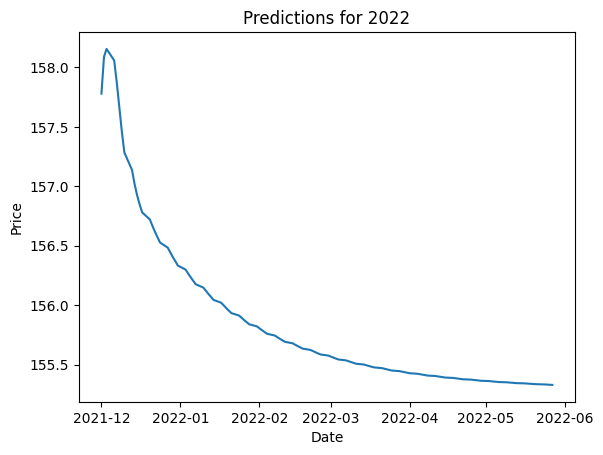

In [23]:
# Chuyển dataframe thành mảng numpy
forecast_data_array = forecast_data.values
# Trích xuất cột ngày và cột dự đoán
dates = forecast_data_array[:, 0]
predictions = forecast_data_array[:, 1]
plt.plot(dates, predictions)
plt.title('Predictions for 2022')
plt.xlabel('Date')
plt.ylabel('Price')
print("=================================================================")
print("Hiển thị biểu đồ giá dự đoán từ ngày 1/12/2021 đến ngày 31/5/2022")
plt.show()